In [1]:
import logging
import warnings
import copy
import os
from pathlib import Path
import warnings
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

Importing plotly failed. Interactive plots will not work.


### Fun

In [2]:
def get_data():
    train_data = pd.read_csv('../data/dengue_features_train.csv')
    train_label = pd.read_csv('../data/dengue_labels_train.csv')
    dataset = train_data.merge(
        train_label, how = 'inner',
        on = ['city', 'year', 'weekofyear']
    )
    return dataset


def process_data_features(sj_data):
    sj_data.reset_index()
    sj_data.loc[:, "time_idx"] =  sj_data.index
    #sj_data["time_idx"] = sj_data.year*52+sj_data.weekofyear
    if "total_cases" in sj_data.columns:
        sj_data.loc[:, 'total_cases'] = sj_data.loc[:, 'total_cases'].astype(float)
    sj_data.loc[:, 'week_start_date'] = pd.to_datetime(sj_data.week_start_date, format='%Y-%m-%d')
    sj_data.loc[:, "month"] = sj_data.week_start_date.dt.month.astype(str).astype("category")  # categories have be strings
    sj_data = sj_data.ffill(axis = 0)
    sj_data = sj_data[sj_data.weekofyear<53]
    return sj_data

def get_test_data():
    test_data = pd.read_csv('../data/dengue_features_test.csv', parse_dates=[3])
    return test_data

def get_exogenous(df_train, df_test, ds, regressors):
    return pd.concat([df_train.loc[:, [ds] + regressors], df_test.loc[:, [ds] + regressors]]).set_index(ds)


### Utils

In [3]:
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

### Define datasets

In [4]:
pd.options.mode.chained_assignment = None

# Train
train_data = get_data()
sj_data = process_data_features(train_data.loc[train_data.city == 'sj', :])
iq_data = process_data_features(train_data.loc[train_data.city == 'iq', :])

# Test
test_data = get_test_data()
sj_test_data = process_data_features(test_data.loc[test_data.city == 'sj', :])
iq_test_data = process_data_features(test_data.loc[test_data.city == 'iq', :])

# Horizon
sj_horizon = sj_test_data.shape[0]
iq_horizon = iq_test_data.shape[0]

# Define time index, target and regressors
index = "week_start_date"
target = "total_cases"
regressors = list(set(train_data.columns) - {index, target, "city", "year", "weekofyear"})

# Exogenous only
sj_exog_df = get_exogenous(sj_data, sj_test_data, index, regressors)
iq_exog_df = get_exogenous(iq_data, iq_test_data, index, regressors)


/var/folders/fl/f868q2894jng9pn4_6v3z1l80000gn/T/ipykernel_73750/3215629900.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sj_data.loc[:, 'total_cases'] = sj_data.loc[:, 'total_cases'].astype(float)
/var/folders/fl/f868q2894jng9pn4_6v3z1l80000gn/T/ipykernel_73750/3215629900.py:17: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sj_data.loc[:, 'week_start_date'] = pd.to_datetime(sj_data.week_start_date, format='%Y-%m-%d')
/var/folders/fl/f868q2894jng9pn4_6v3z1l80000gn/T/ipykernel_73750/3215629900.py:16: FutureWarning: In a future version, `df.iloc

### San Juan Basic EDA 

In [5]:
sj_data.describe(include='all')

/var/folders/fl/f868q2894jng9pn4_6v3z1l80000gn/T/ipykernel_73750/3016944619.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  sj_data.describe(include='all')


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,time_idx,month
count,933,933.000000,933.000000,933,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,...,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933
unique,1,NaN,NaN,933,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
top,sj,NaN,NaN,1990-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
freq,933,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90
first,NaN,NaN,NaN,1990-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2008-04-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1998.826367,26.418006,NaN,0.057992,0.066891,0.176312,0.166237,35.268939,299.160747,...,16.549256,2.516200,27.002312,6.757357,31.602787,22.595177,26.745445,34.184352,467.553055,NaN
std,NaN,5.213044,14.970535,NaN,0.104879,0.091286,0.057596,0.055779,44.538098,1.237472,...,1.561350,0.498226,1.416255,0.835324,1.718753,1.508349,29.287338,51.451301,270.391352,NaN
min,NaN,1990.000000,1.000000,NaN,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,295.938571,...,11.715714,1.357143,22.842857,4.528571,26.700000,17.800000,0.000000,0.000000,0.000000,NaN
25%,NaN,1994.000000,13.000000,NaN,0.005400,0.016300,0.137757,0.129786,0.000000,298.194286,...,15.235714,2.157143,25.842857,6.200000,30.600000,21.700000,6.900000,9.000000,234.000000,NaN


In [6]:
# Type
sj_data.dtypes

city                                             object
year                                              int64
weekofyear                                        int64
week_start_date                          datetime64[ns]
ndvi_ne                                         float64
ndvi_nw                                         float64
ndvi_se                                         float64
ndvi_sw                                         float64
precipitation_amt_mm                            float64
reanalysis_air_temp_k                           float64
reanalysis_avg_temp_k                           float64
reanalysis_dew_point_temp_k                     float64
reanalysis_max_air_temp_k                       float64
reanalysis_min_air_temp_k                       float64
reanalysis_precip_amt_kg_per_m2                 float64
reanalysis_relative_humidity_percent            float64
reanalysis_sat_precip_amt_mm                    float64
reanalysis_specific_humidity_g_per_kg           

In [7]:
# compute the correlations
sj_correlations = sj_data.iloc[:, 4:-2].corr()
iq_correlations = iq_data.iloc[:, 4:-2].corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

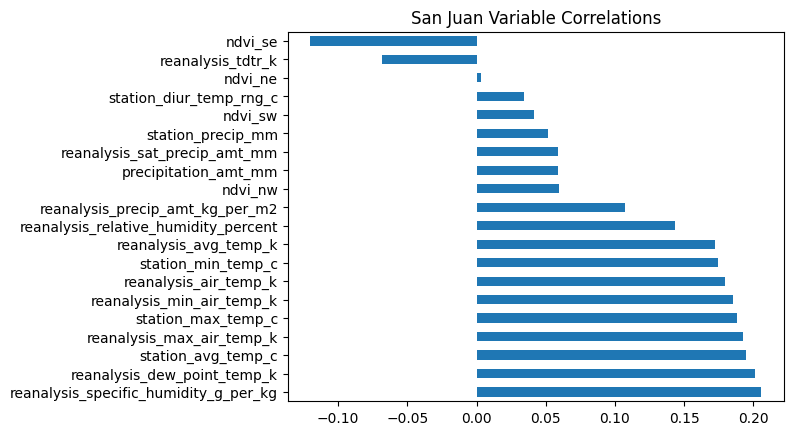

In [8]:
# Plot SJ correlation
(
    sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh()
)
plt.title('San Juan Variable Correlations')

Text(0.5, 1.0, 'Iquito Variable Correlations')

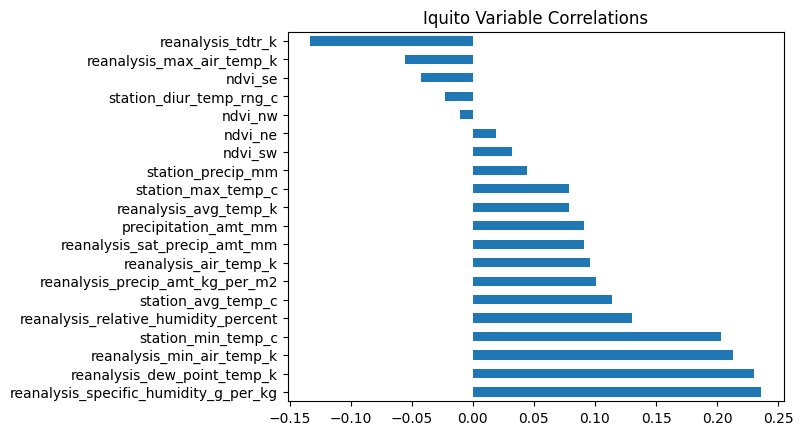

In [9]:
# Plot IQ correlation
(
    iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh()
)
plt.title('Iquito Variable Correlations')

### Using Prophet


In [10]:
def model_builder(
    df,
    ds,
    target,
    regressors,
    cv_initial,
    cv_horizon,
    n_skip_period,
    growth,
    weekly_seasonality,
    yearly_seasonality,
    changepoint_prior_scale,
    seasonality_prior_scale,
    regressor_prior_scale,
    seasonality_mode,
    verbose,
):
    model = Prophet(
        growth=growth,
        weekly_seasonality=weekly_seasonality,
        yearly_seasonality=yearly_seasonality,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
    )

    for regressor in regressors:
        model.add_regressor(
            name=regressor, prior_scale=regressor_prior_scale
        )

    # Reformat input
    train = df.loc[:, [ds, target] + regressors]
    train.rename(columns={ds: "ds", target: "y"}, inplace=True)
    # Skip days
    train = train.iloc[n_skip_period:, :]
    
    # fit
    with suppress_stdout_stderr():
        model.fit(train)
        if cv_horizon and cv_initial:
            df_cv = cross_validation(
                model,
                initial=f"{cv_initial} W",
                horizon=f"{cv_horizon} W",
                parallel="processes",
            )
            pm = performance_metrics(df_cv)
            mae = np.mean(pm["mae"])
    
    if verbose:
        # print(pm)
        if cv_horizon and cv_initial:
            print(
                f"Cross validation applied with inital {cv_initial} weeks,"
                f"and horizon {cv_horizon} weeks."
            )
            print(f"Average MAE is {mae:.1f}\n")
    return model, mae


def model_predict(model, exog_df, horizon, ds):
    future_dates = (
        model.make_future_dataframe(exog_df.shape[0])
        .merge(exog_df.reset_index(), how="inner", left_on="ds", right_on=ds)
    )
    forecast = model.predict(future_dates)
    return forecast


def grid_search(df, params, grid_params, sample=None):
    tmp_params = copy.deepcopy(params)
    tracking = []
    models = []
    hp_grid = list(ParameterGrid(grid_params))
    cv_metrics = "mae"
    if sample:
        sample = min(len(hp_grid), sample)
        hp_grid = np.random.choice(hp_grid, sample, replace=False)
    print(f"Grid search: searching through {len(hp_grid)} combinations")

    for i, p in enumerate(hp_grid):
        tmp_params.update(**p)
        m, error = model_builder(df=df, **tmp_params)
        tracking.append(error)
        models.append(m)
        if params["verbose"]:
            print(f"Model {i} result for {p}: {cv_metrics}={error}")

    best_idx = np.argmin(tracking)
    best_model = models[best_idx]
    best_params = tmp_params.update(hp_grid[best_idx])
    best_mape = tracking[best_idx]
    
    print(f"Best model is {hp_grid[best_idx]}: {cv_metrics}={best_mape}")
    return best_model, best_params, best_mape 

### Case 1: San Juan - No regressor

In [11]:
params = {
    "ds": index,
    "target": target,
    "regressors": [],
    "verbose": False,
    "cv_initial": 5*52,
    "cv_horizon": 26,
    "n_skip_period": 0,
    "growth": "linear",
    "weekly_seasonality": False,
    "yearly_seasonality": "auto",
}
grid_params = {
    "seasonality_mode": ['additive', 'multiplicative'],
    "changepoint_prior_scale": [.001, 0.01, 0.1],
    "seasonality_prior_scale":[.01, .1, 1],
    "regressor_prior_scale": [.01, .1, 1],
}

model_simple, best_params, best_mae = grid_search(
    df=sj_data, params=params, grid_params=grid_params, sample=20
)

Grid search: searching through 20 combinations


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Making 51 forecasts with cutoffs between 1995-05-09 00:00:00 and 2007-10-23 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x295078f10>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Best model is {'changepoint_prior_scale': 0.01, 'regressor_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}: mae=27.187676727928586


/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


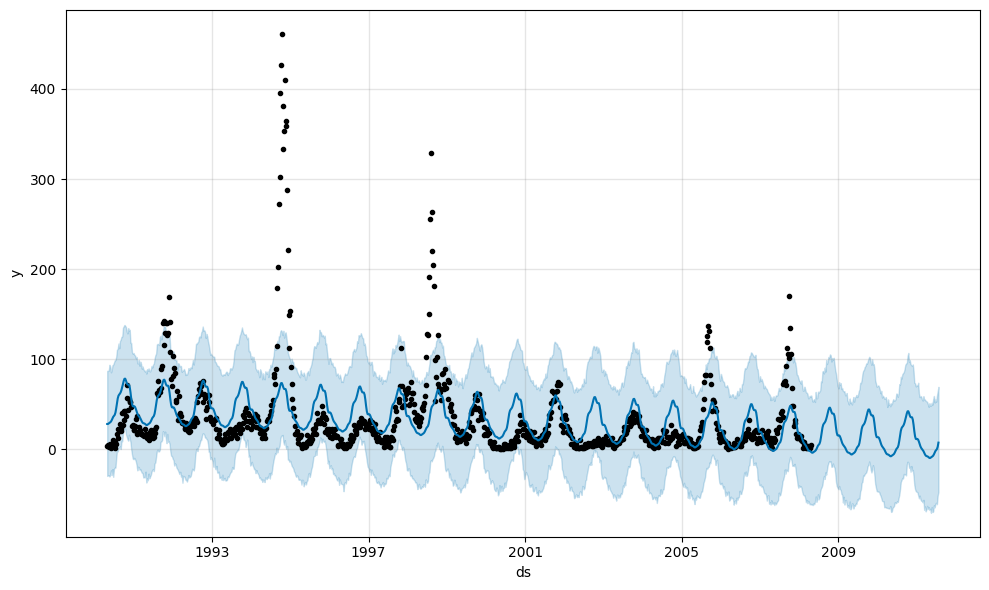

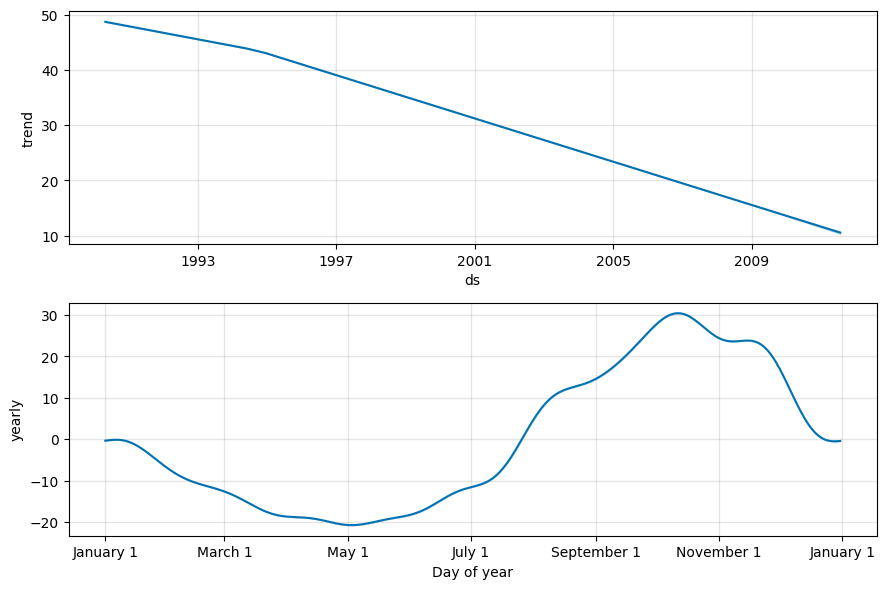

In [12]:
# Predictions
sj_pred = model_predict(
    model=model_simple,
    exog_df=sj_exog_df.loc[:, []],
    horizon=sj_horizon,
    ds=index
)
fig = model_simple.plot(sj_pred);
comp_fig = model_simple.plot_components(sj_pred);

### Case 2: Grid Search using all regressors

In [13]:
params = {
    "ds": index,
    "target": target,
    "regressors": regressors,
    "verbose": False,
    "cv_initial": 5*52,
    "cv_horizon": 26,
    "n_skip_period": 0,
    "growth": "linear",
    "weekly_seasonality": False,
    "yearly_seasonality": "auto",
}
grid_params = {
    "seasonality_mode": ['additive', 'multiplicative'],
    "changepoint_prior_scale": [.001, 0.01, 0.1],
    "seasonality_prior_scale":[.01, .1, 1],
    "regressor_prior_scale": [.01, .1, 1],
}

model_all_features, best_params, best_mae = grid_search(
    df=sj_data, params=params, grid_params=grid_params, sample=20
)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Making 51 forecasts with cutoffs between 1995-05-09 00:00:00 and 2007-10-23 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x16fd2f820>


Grid search: searching through 20 combinations


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Making 51 forecasts with cutoffs between 1995-05-09 00:00:00 and 2007-10-23 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x28f4354f0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

Best model is {'changepoint_prior_scale': 0.01, 'regressor_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}: mae=28.633066315529238


/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


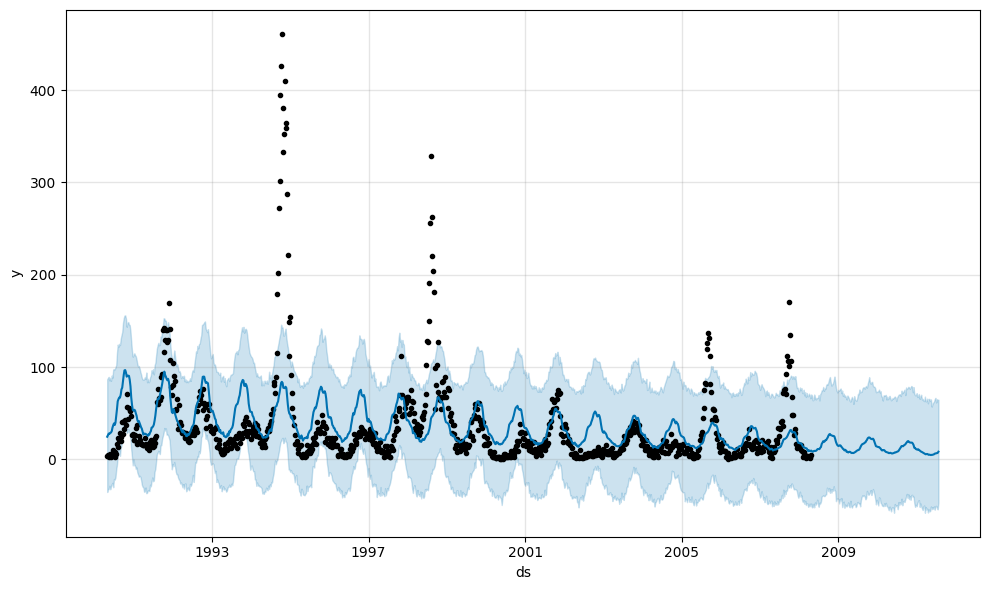

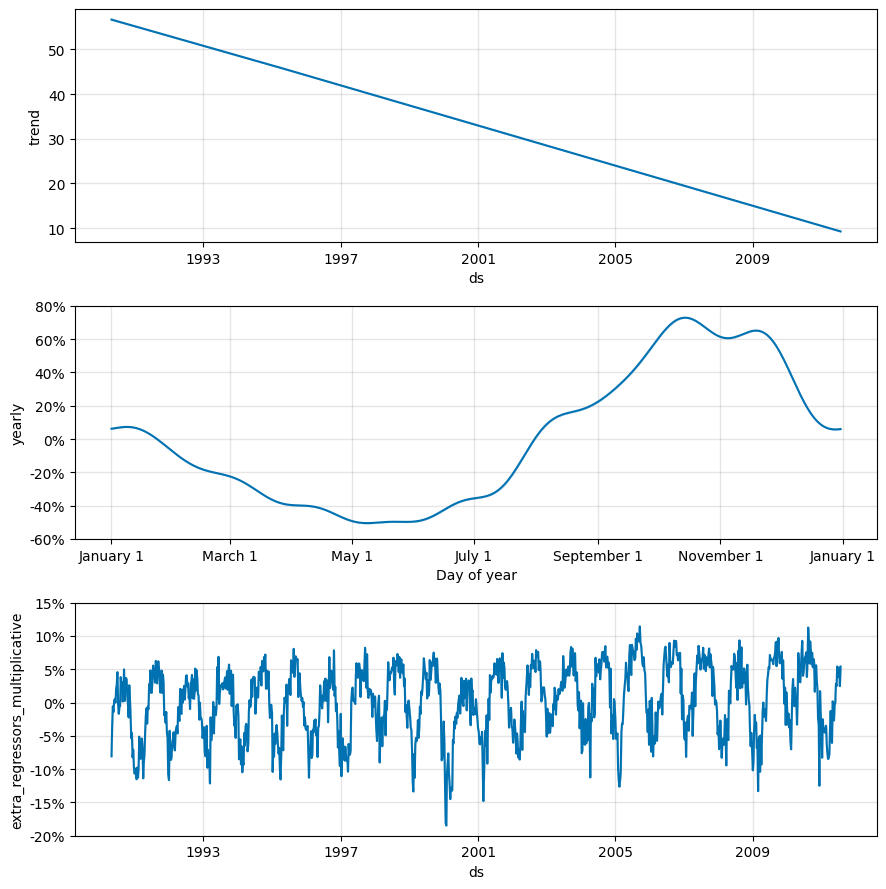

In [14]:
# Predictions
sj_pred = model_predict(
    model=model_all_features,
    exog_df=sj_exog_df.loc[:, regressors],
    horizon=sj_horizon,
    ds=index
)
fig = model_all_features.plot(sj_pred); 
comp_fig = model_all_features.plot_components(sj_pred);

### Case 3 - Grid Search using only humidity and precipitation

In [15]:
params = {
    "ds": index,
    "target": target,
    "regressors": [
        "reanalysis_specific_humidity_g_per_kg",
        "reanalysis_dew_point_temp_k",
        "station_min_temp_c",
        "station_avg_temp_c",
    ],
    "verbose": False,
    "cv_initial": 5*52,
    "cv_horizon": 26,
    "n_skip_period": 0,
    "growth": "linear",
    "weekly_seasonality": False,
    "yearly_seasonality": "auto",
}
grid_params = {
    "seasonality_mode": ['additive', 'multiplicative'],
    "changepoint_prior_scale": [.001, 0.01, 0.1],
    "seasonality_prior_scale":[.01, .1, 1],
    "regressor_prior_scale": [.01, .1, 1],
}

model_humidity, best_params, best_mae = grid_search(
    df=sj_data, params=params, grid_params=grid_params, sample=20
)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Making 51 forecasts with cutoffs between 1995-05-09 00:00:00 and 2007-10-23 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x16e6b6f40>


Grid search: searching through 20 combinations


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Making 51 forecasts with cutoffs between 1995-05-09 00:00:00 and 2007-10-23 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x16e7d6310>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

Best model is {'changepoint_prior_scale': 0.01, 'regressor_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}: mae=27.725288273530822


/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


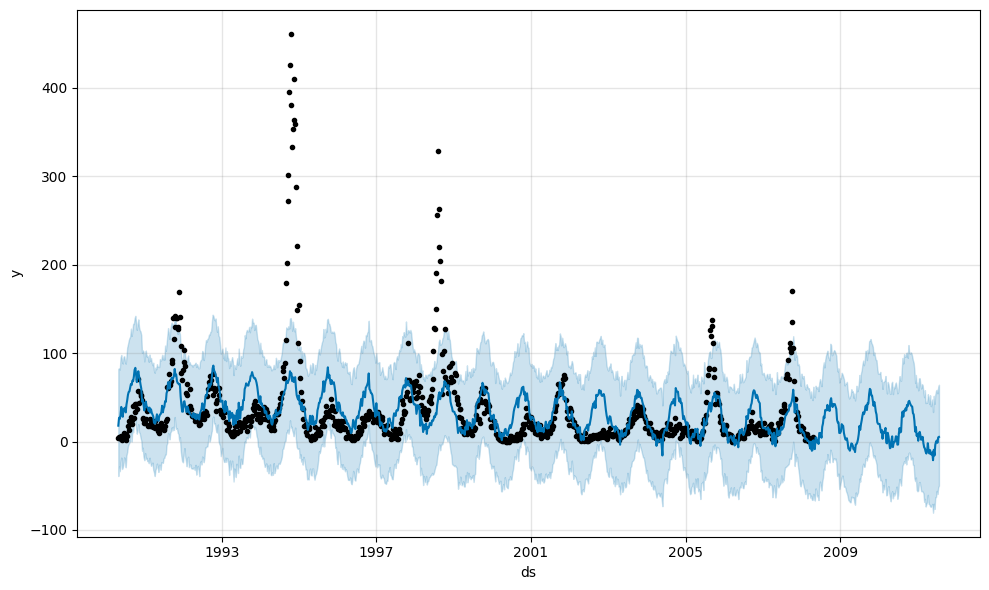

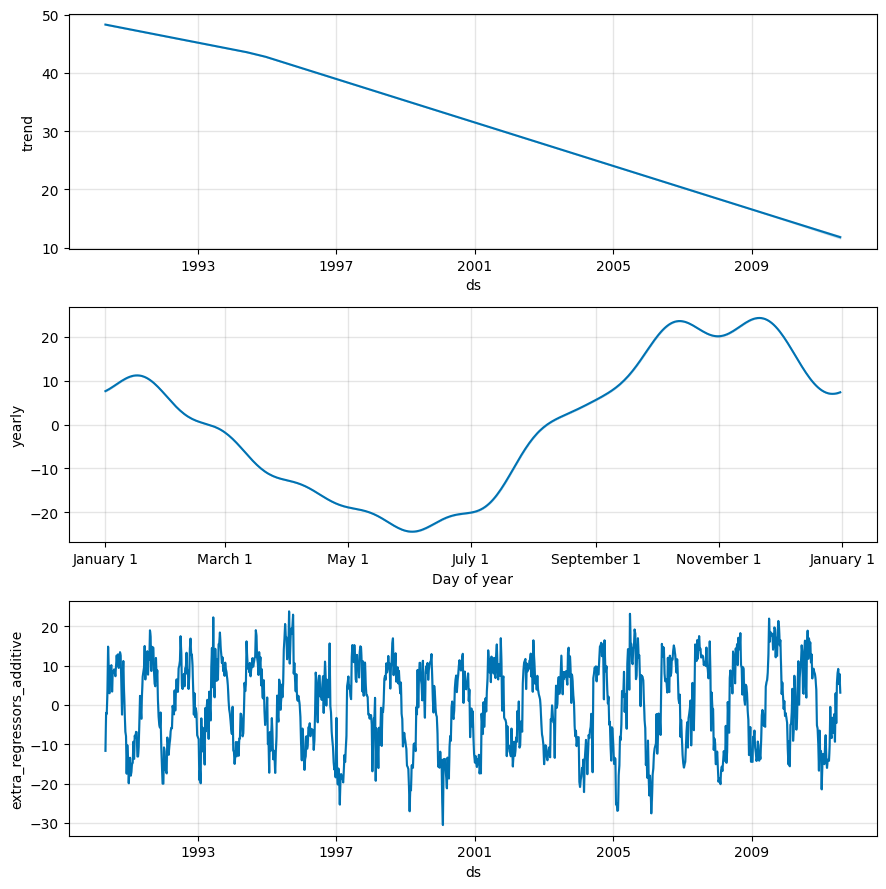

In [16]:
# Predictions
sj_pred = model_predict(
    model=model_humidity,
    exog_df=sj_exog_df.loc[:, params["regressors"]],
    horizon=sj_horizon,
    ds=index
)
fig = model_humidity.plot(sj_pred);
comp_fig = model_humidity.plot_components(sj_pred);

### Iquitos - Using humidity and precipitation

In [17]:
params = {
    "ds": index,
    "target": target,
    "regressors": [
        "reanalysis_specific_humidity_g_per_kg",
        "reanalysis_dew_point_temp_k",
        "station_min_temp_c",
        "station_avg_temp_c",
    ],
    "verbose": False,
    "cv_initial": 5*52,
    "cv_horizon": 26,
    "n_skip_period": 0,
    "growth": "linear",
    "weekly_seasonality": False,
    "yearly_seasonality": "auto",
}
grid_params = {
    "seasonality_mode": ['additive', 'multiplicative'],
    "changepoint_prior_scale": [.001, 0.01, 0.1],
    "seasonality_prior_scale":[.01, .1, 1],
    "regressor_prior_scale": [.01, .1, 1],
}

# Train
model_humidity, best_params, best_mae = grid_search(
    df=iq_data, params=params, grid_params=grid_params, sample=20
)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Making 19 forecasts with cutoffs between 2005-07-01 00:00:00 and 2009-12-25 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x28f32e640>


Grid search: searching through 20 combinations


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Making 19 forecasts with cutoffs between 2005-07-01 00:00:00 and 2009-12-25 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x28f68a1f0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

Best model is {'changepoint_prior_scale': 0.01, 'regressor_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}: mae=8.029833196137679


/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/linlincheng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


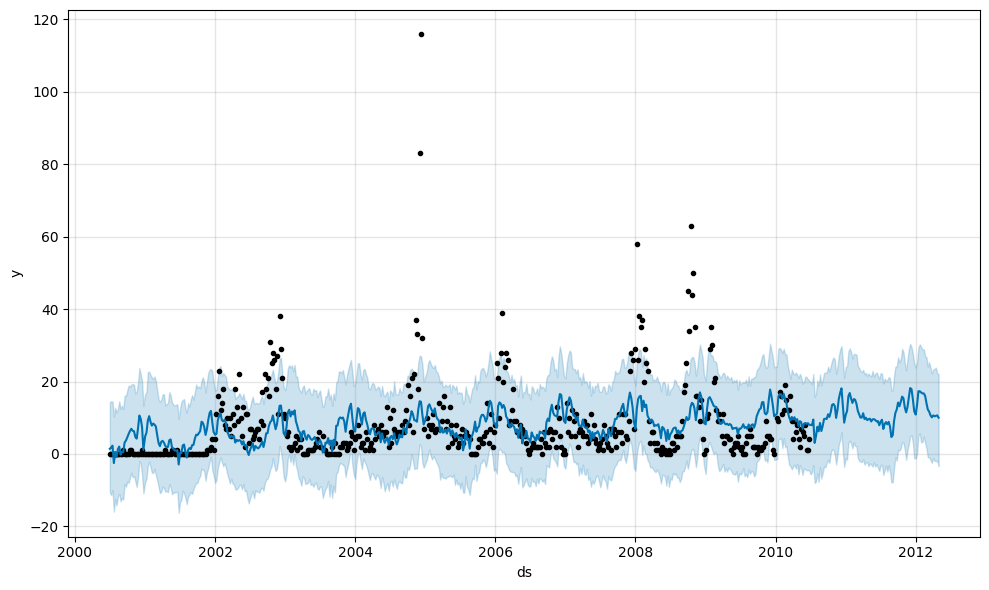

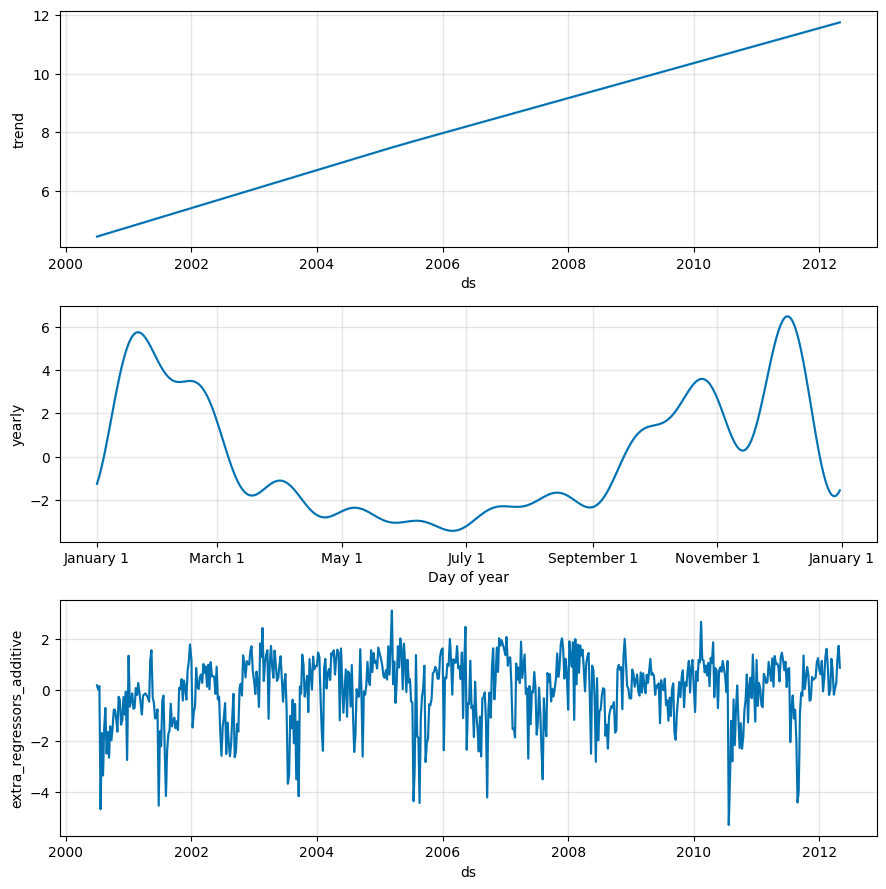

In [18]:
# Predictions
iq_pred = model_predict(
    model=model_humidity,
    exog_df=iq_exog_df.loc[:, params["regressors"]],
    horizon=iq_horizon,
    ds=index
)
fig = model_humidity.plot(iq_pred);
comp_fig = model_humidity.plot_components(iq_pred);

### Final

In [19]:
sj_pred.loc[sj_pred["yhat"] < 0, "yhat"] = 0
iq_pred.loc[iq_pred["yhat"] < 0, "yhat"] = 0

sj_result_df = (
    sj_test_data
    .loc[:, ["city", "year", "weekofyear", "week_start_date"]]
    .merge(sj_pred.loc[:, ["ds", "yhat"]], how="inner", left_on="week_start_date", right_on="ds")
    .rename(columns={"yhat": "total_cases"})
    .drop(["ds", "week_start_date"], axis=1)
)

iq_result_df = (
    iq_test_data
    .loc[:, ["city", "year", "weekofyear", "week_start_date"]]
    .merge(iq_pred.loc[:, ["ds", "yhat"]], how="inner", left_on="week_start_date", right_on="ds")
    .rename(columns={"yhat": "total_cases"})
    .drop(["ds", "week_start_date"], axis=1)
)

result_df = pd.concat([sj_result_df, iq_result_df])
result_df.to_csv("submission.csv", index=False)

result_df.head(20)

,city,year,weekofyear,total_cases
0,sj,2008,18,0.000000
1,sj,2008,19,0.000000
2,sj,2008,20,4.376862
3,sj,2008,21,4.504795
4,sj,2008,22,0.000000
5,sj,2008,23,1.507394
6,sj,2008,24,0.000000
7,sj,2008,25,9.637228
8,sj,2008,26,9.592170
9,sj,2008,27,8.843112


<AxesSubplot: >

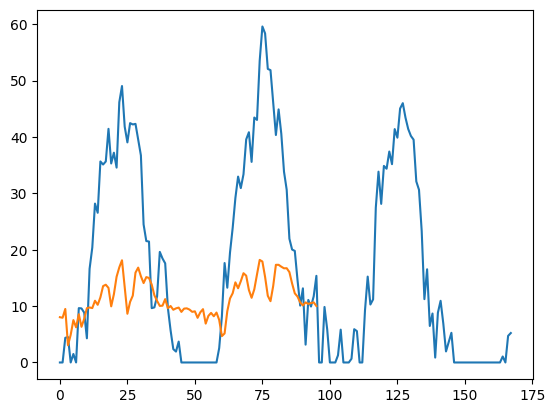

In [23]:
result_df.loc[result_df.city=='sj', 'total_cases'].plot()
result_df.loc[result_df.city=='iq', 'total_cases'].plot()